# USD-MNT Machine Learning Forecast

In [264]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

plt.style.use('/storage/mds.mplstyle')

In [265]:
df = pd.read_csv('Data/Modified Data/data.csv', thousands=',')

In [266]:
df = df.set_index('Date')

In [267]:
df.tail()

,USD,cpi,m2,m1,current,capital,financial,errors,balance
Date,,,,,,,,,
2018-06-30,2462.82,0.5,17342.9,3352.9,-319.4,26.5,-376.6,-176.7,822.2
2018-07-31,2463.25,0.5,17189.3,3086.0,NaN,NaN,NaN,NaN,851.0
2018-08-31,2472.99,-0.8,17440.8,3222.8,NaN,NaN,NaN,NaN,869.2
2018-09-30,2552.13,-0.1,17911.8,3412.7,NaN,NaN,NaN,NaN,931.7
2018-10-31,2564.44,1.0,18311.5,3428.6,NaN,NaN,NaN,NaN,1069.2


This dataframe will be used to make forecasts after the model is created.

In [268]:
forecast2 = df.iloc[-48:]

### Description of features
We have 15 features that we will be using to predict our exchange rate. A brief description of each is below:

- CPI - consumer price index. This is the change in CPI from the previous month in percent.
- m2 money supply
- m1 money supply
- quasi money: is a term used in economics to describe highly liquid assets which are not cash but can easily be converted into cash (from wikipedia)
- circulation: money in circulation
- domestic: interest rates on loans made in Mongolian Tugrik
- foreign: interest rates on loans made in foreign currency
- current: the current account from the balance of payments
- capital: the capital account from the balance of payments
- financial: the financial account from the balance of payments
- errors: errors and omissions from the balance of payments
- export: total value of exports from Mongolia
- imports: total value of imports to Mongolia
- balance: the balance of exports and imports in Mongolia
- government_balance: monetary balance of the government account. 

## Visualize Features and Relationships
As all of our features are numeric, we have little work to do converting them. This also allows us to compare our features very easily. One issue with our data is that there are a few empty values at the end of our dataframe. We can easily fill those for now so we can make our visualizations.

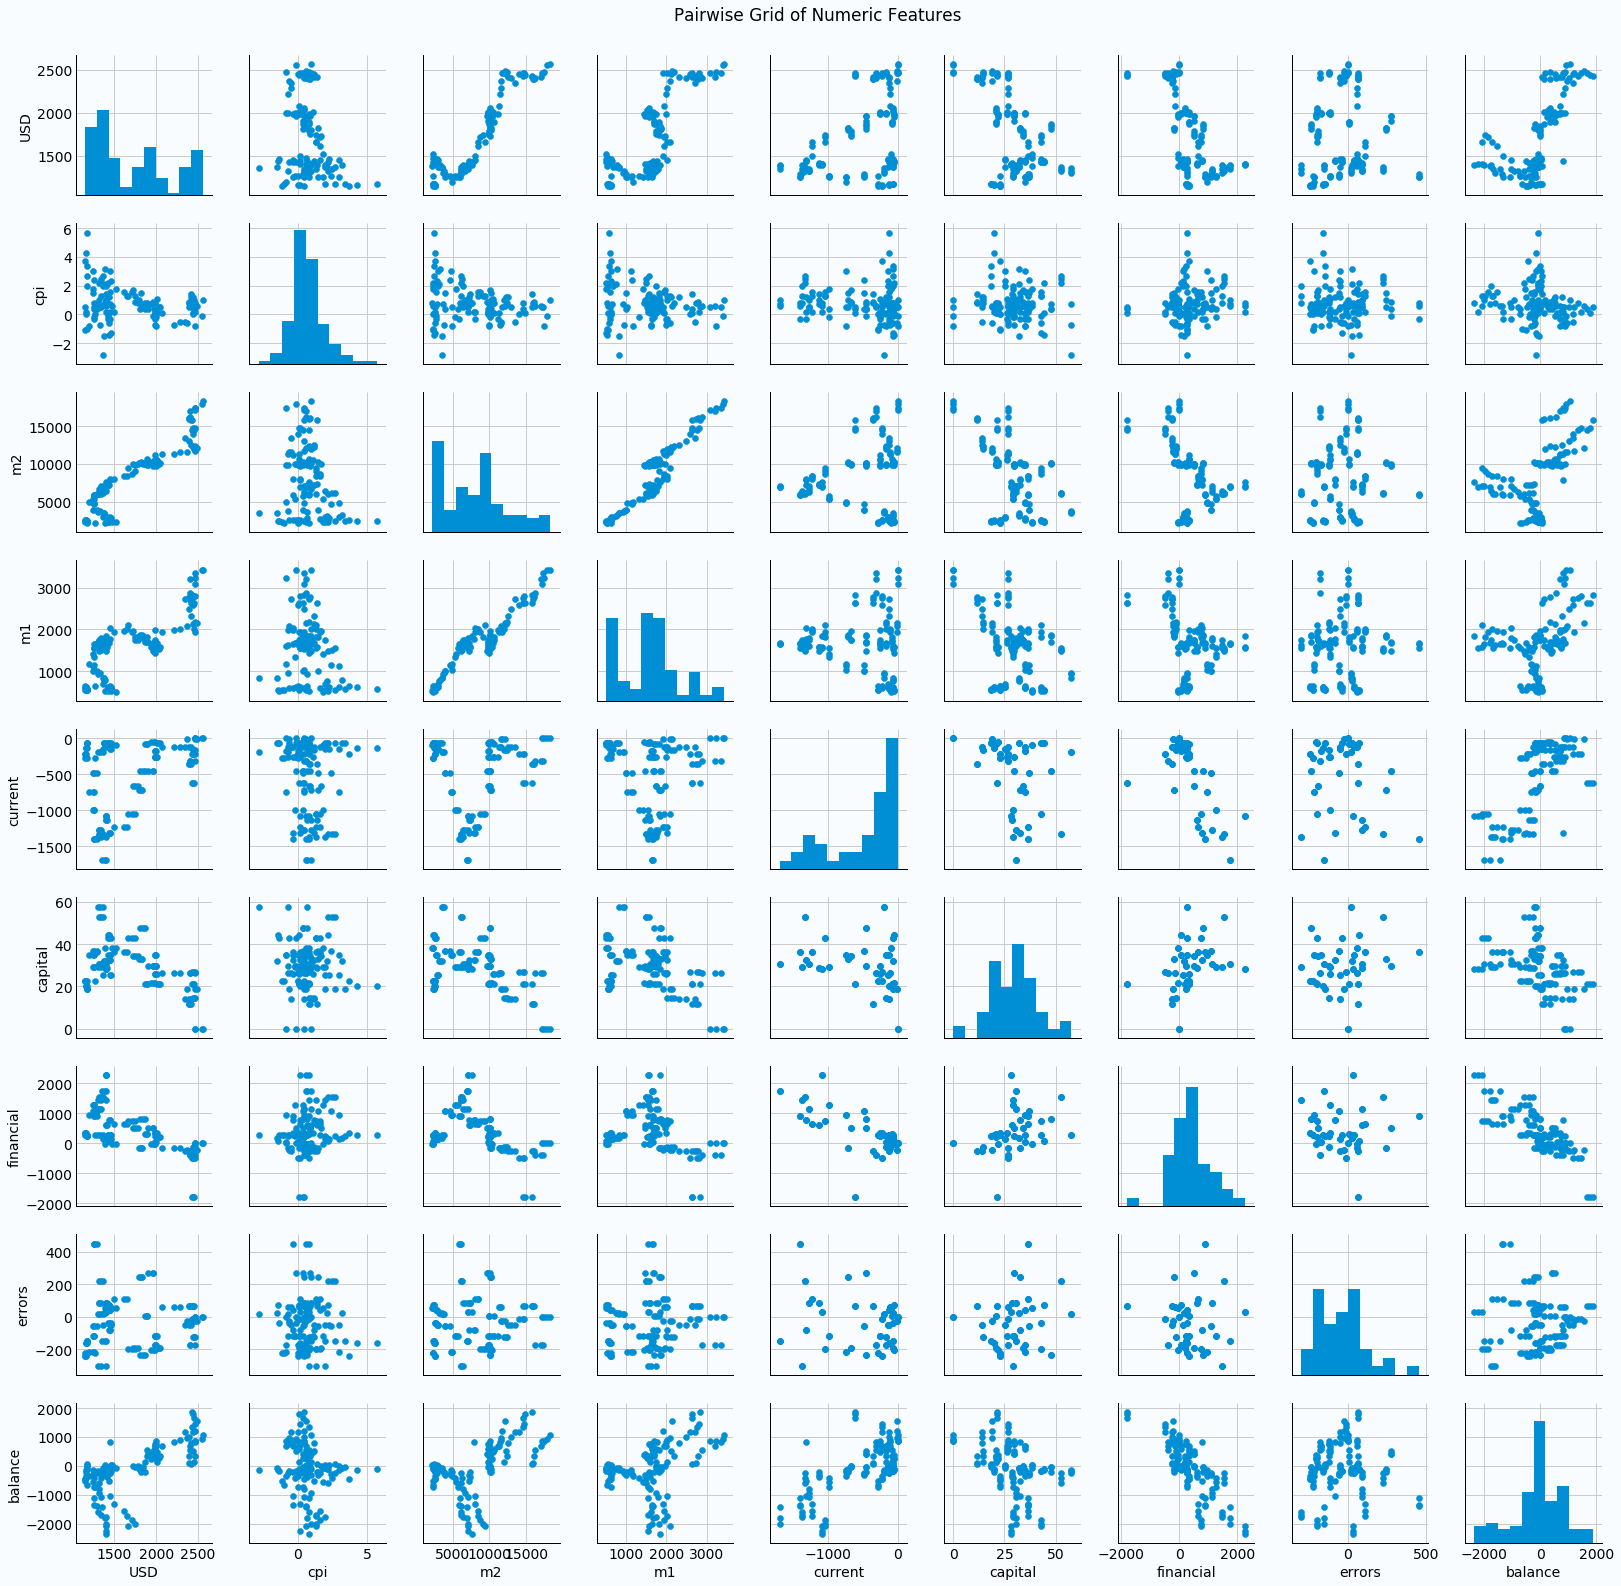

In [182]:
# Seaborn doesn't handle NaN values, so we can fill them with 0 for now.
df = df.fillna(value=0)

# Pair grid of key variables.
g = sns.PairGrid(df)
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
plt.subplots_adjust(top=0.95)
g.fig.suptitle('Pairwise Grid of Numeric Features');

Text(0.5,1,'Correlation Heatmap of Numeric Features')

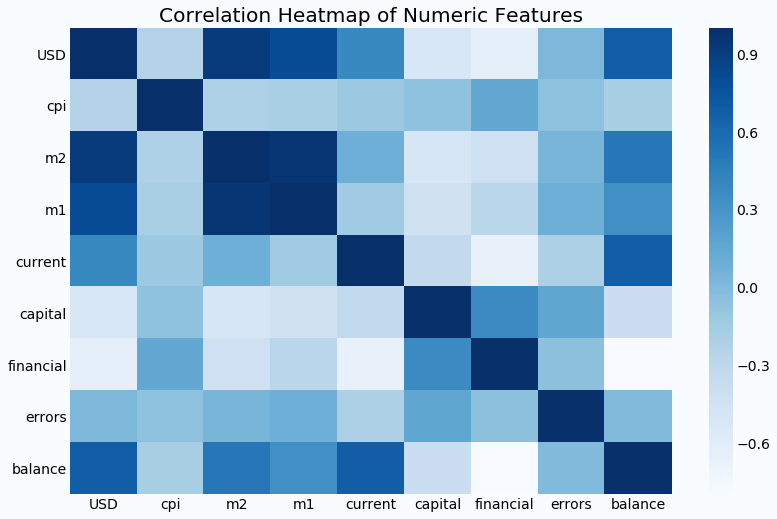

In [183]:
corr = df.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, cmap='Blues')
plt.title('Correlation Heatmap of Numeric Features')

Use the convenience function below we can plot two of our features over time. This can give us a visual way to understand how these variables correlate outside of a correlation function. 

## Create lag and future values for forecasting.

First we will create our future values. We will use 3 months in the future as our y variable. These are what we will be trying to predict.

In [184]:
df['y3'] = df.USD.shift(-3)
df['y6'] = df.USD.shift(-6)
df['y12'] = df.USD.shift(-12)

In [185]:
df.tail()

,USD,cpi,m2,m1,current,capital,financial,errors,balance,y3,y6,y12
Date,,,,,,,,,,,,
2018-06-30,2462.82,0.5,17342.9,3352.9,-319.4,26.5,-376.6,-176.7,822.2,2552.13,NaN,NaN
2018-07-31,2463.25,0.5,17189.3,3086.0,0.0,0.0,0.0,0.0,851.0,2564.44,NaN,NaN
2018-08-31,2472.99,-0.8,17440.8,3222.8,0.0,0.0,0.0,0.0,869.2,NaN,NaN,NaN
2018-09-30,2552.13,-0.1,17911.8,3412.7,0.0,0.0,0.0,0.0,931.7,NaN,NaN,NaN
2018-10-31,2564.44,1.0,18311.5,3428.6,0.0,0.0,0.0,0.0,1069.2,NaN,NaN,NaN


Next we can create our lag values. We have to be careful though, as the curse of dimensionality can strike if our dataframe becomes too wide.

In [186]:
def feature_lag(features):
    for feature in features:
        df[feature + '-lag1'] = df[feature].shift(1)
        df[feature + '-lag2'] = df[feature].shift(2)
        df[feature + '-lag3'] = df[feature].shift(3)
        df[feature + '-lag4'] = df[feature].shift(4)

In [187]:
df.columns

Index(['USD', 'cpi', 'm2', 'm1', 'current', 'capital', 'financial', 'errors',
       'balance', 'y3', 'y6', 'y12'],
      dtype='object')

In [188]:
features = ['USD', 'm2', 'm1', 'current', 'capital', 'financial', 'errors', 'balance']

In [189]:
feature_lag(features)

In [190]:
df.head()

,USD,cpi,m2,m1,current,capital,financial,errors,balance,y3,...,financial-lag3,financial-lag4,errors-lag1,errors-lag2,errors-lag3,errors-lag4,balance-lag1,balance-lag2,balance-lag3,balance-lag4
Date,,,,,,,,,,,,,,,,,,,,,
2008-01-31,1171.77,2.0,2307.0,551.9,-63.3,18.6,242.7,-147.4,17.6,1164.94,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-02-29,1171.82,2.7,2417.2,549.2,-63.3,18.6,242.7,-147.4,57.3,1161.37,...,NaN,NaN,-147.4,NaN,NaN,NaN,17.6,NaN,NaN,NaN
2008-03-31,1168.17,3.4,2454.8,577.7,-63.3,18.6,242.7,-147.4,-19.5,1158.12,...,NaN,NaN,-147.4,-147.4,NaN,NaN,57.3,17.6,NaN,NaN
2008-04-30,1164.94,5.7,2466.3,583.7,-130.6,20.1,282.8,-161.4,-93.5,1155.35,...,242.7,NaN,-147.4,-147.4,-147.4,NaN,-19.5,57.3,17.6,NaN
2008-05-31,1161.37,4.3,2516.2,620.6,-130.6,20.1,282.8,-161.4,-153.4,1150.91,...,242.7,242.7,-161.4,-147.4,-147.4,-147.4,-93.5,-19.5,57.3,17.6


In [191]:
df.tail()

,USD,cpi,m2,m1,current,capital,financial,errors,balance,y3,...,financial-lag3,financial-lag4,errors-lag1,errors-lag2,errors-lag3,errors-lag4,balance-lag1,balance-lag2,balance-lag3,balance-lag4
Date,,,,,,,,,,,,,,,,,,,,,
2018-06-30,2462.82,0.5,17342.9,3352.9,-319.4,26.5,-376.6,-176.7,822.2,2552.13,...,-239.1,-239.1,-176.7,-176.7,66.9,66.9,706.4,543.4,351.94,112.40
2018-07-31,2463.25,0.5,17189.3,3086.0,0.0,0.0,0.0,0.0,851.0,2564.44,...,-376.6,-239.1,-176.7,-176.7,-176.7,66.9,822.2,706.4,543.40,351.94
2018-08-31,2472.99,-0.8,17440.8,3222.8,0.0,0.0,0.0,0.0,869.2,NaN,...,-376.6,-376.6,0.0,-176.7,-176.7,-176.7,851.0,822.2,706.40,543.40
2018-09-30,2552.13,-0.1,17911.8,3412.7,0.0,0.0,0.0,0.0,931.7,NaN,...,-376.6,-376.6,0.0,0.0,-176.7,-176.7,869.2,851.0,822.20,706.40
2018-10-31,2564.44,1.0,18311.5,3428.6,0.0,0.0,0.0,0.0,1069.2,NaN,...,0.0,-376.6,0.0,0.0,0.0,-176.7,931.7,869.2,851.00,822.20


## Feature Engineering

Our date field is currently our index. We can create date features to give our model some information about time.

In [192]:
df['date'] = df.index

In [193]:
df['date'] = pd.to_datetime(df.date)

In [194]:
import datetime as dt
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

In [195]:
df.drop(labels='date', axis=1, inplace=True)

Adding in the difference between time steps can be a useful feature.

In [196]:
df['USD-lag1-diff'] = df['USD'] - df['USD-lag1']
df['USD-lag2-diff'] = df['USD-lag1'] - df['USD-lag2']
df['USD-lag3-diff'] = df['USD-lag2'] - df['USD-lag3']

In [197]:
df.columns

Index(['USD', 'cpi', 'm2', 'm1', 'current', 'capital', 'financial', 'errors',
       'balance', 'y3', 'y6', 'y12', 'USD-lag1', 'USD-lag2', 'USD-lag3',
       'USD-lag4', 'm2-lag1', 'm2-lag2', 'm2-lag3', 'm2-lag4', 'm1-lag1',
       'm1-lag2', 'm1-lag3', 'm1-lag4', 'current-lag1', 'current-lag2',
       'current-lag3', 'current-lag4', 'capital-lag1', 'capital-lag2',
       'capital-lag3', 'capital-lag4', 'financial-lag1', 'financial-lag2',
       'financial-lag3', 'financial-lag4', 'errors-lag1', 'errors-lag2',
       'errors-lag3', 'errors-lag4', 'balance-lag1', 'balance-lag2',
       'balance-lag3', 'balance-lag4', 'month', 'year', 'USD-lag1-diff',
       'USD-lag2-diff', 'USD-lag3-diff'],
      dtype='object')

## Prepare dataset for models

Once we settle on a model we will make predictions using the last complete data available, which is June 2018. Here we will slice out that month and create an array we will make predictions on.

In [198]:
forecast = df[-5:-4].drop(labels=['y3','y6','y12'], axis=1)

In [199]:
df.head()

,USD,cpi,m2,m1,current,capital,financial,errors,balance,y3,...,errors-lag4,balance-lag1,balance-lag2,balance-lag3,balance-lag4,month,year,USD-lag1-diff,USD-lag2-diff,USD-lag3-diff
Date,,,,,,,,,,,,,,,,,,,,,
2008-01-31,1171.77,2.0,2307.0,551.9,-63.3,18.6,242.7,-147.4,17.6,1164.94,...,NaN,NaN,NaN,NaN,NaN,1,2008,NaN,NaN,NaN
2008-02-29,1171.82,2.7,2417.2,549.2,-63.3,18.6,242.7,-147.4,57.3,1161.37,...,NaN,17.6,NaN,NaN,NaN,2,2008,0.05,NaN,NaN
2008-03-31,1168.17,3.4,2454.8,577.7,-63.3,18.6,242.7,-147.4,-19.5,1158.12,...,NaN,57.3,17.6,NaN,NaN,3,2008,-3.65,0.05,NaN
2008-04-30,1164.94,5.7,2466.3,583.7,-130.6,20.1,282.8,-161.4,-93.5,1155.35,...,NaN,-19.5,57.3,17.6,NaN,4,2008,-3.23,-3.65,0.05
2008-05-31,1161.37,4.3,2516.2,620.6,-130.6,20.1,282.8,-161.4,-153.4,1150.91,...,-147.4,-93.5,-19.5,57.3,17.6,5,2008,-3.57,-3.23,-3.65


Our dataset now contains NaN values because of our lag and forward features. We can remove these before we split the data into X's and Y's.

In [200]:
df.dropna(axis=0, inplace=True)

Now we can separate our data into X's and Y's.

In [201]:
y = df[['y3', 'y6', 'y12']]

In [202]:
X = df.drop(['y3', 'y6', 'y12'], axis=1)

In [203]:
#X.to_csv('Data/Modified Data/Training-Test Data/X.csv')
#y.to_csv('Data/Modified Data/Training-Test Data/3y.csv')

In [204]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.20, random_state=42)

## Implement Algorithms

### Linear Regression

In [205]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Create linear regression object
regr = LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
lin_pred = regr.predict(X_test)

In [206]:
linear_regression_score = regr.score(X_test, y_test)
linear_regression_score

0.89498811295844483

In [207]:
from math import sqrt
# The mean squared error
print("Root mean squared error: %.2f"
      % sqrt(mean_squared_error(y_test, lin_pred)))
# The absolute squared error
print("Mean absolute error: %.2f"
      % mean_absolute_error(y_test, lin_pred))
# Explained variance score: 1 is perfect prediction
print('R-squared: %.2f' % r2_score(y_test, lin_pred))

Root mean squared error: 128.82
Mean absolute error: 111.53
R-squared: 0.90


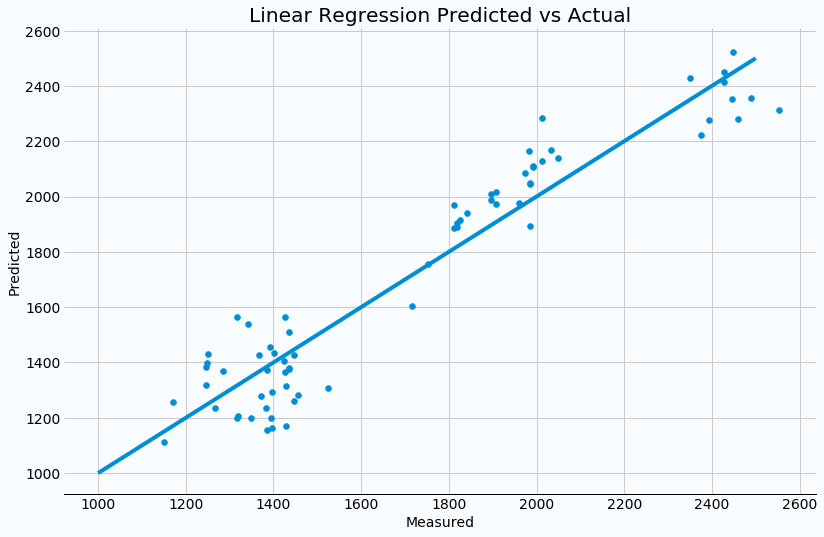

In [208]:
plt.plot( [1000,2500],[1000,2500] )
plt.scatter(y_test, lin_pred)
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('Linear Regression Predicted vs Actual')
plt.show()

### Neural Network Regression

In [209]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Create MLPRegressor object
mlp = MLPRegressor()

# Train the model using the training sets
mlp.fit(X_train, y_train)

# Score the model
neural_network_regression_score = mlp.score(X_test, y_test)
neural_network_regression_score

-0.57591808643780196

In [210]:
# Make predictions using the testing set
nnr_pred = mlp.predict(X_test)

In [211]:
# The mean squared error
print("Root mean squared error: %.2f"
      % sqrt(mean_squared_error(y_test, nnr_pred)))
# The absolute squared error
print("Mean absolute error: %.2f"
      % mean_absolute_error(y_test, nnr_pred))
# Explained variance score: 1 is perfect prediction
print('R-squared: %.2f' % r2_score(y_test, nnr_pred))

Root mean squared error: 499.04
Mean absolute error: 394.42
R-squared: -0.61


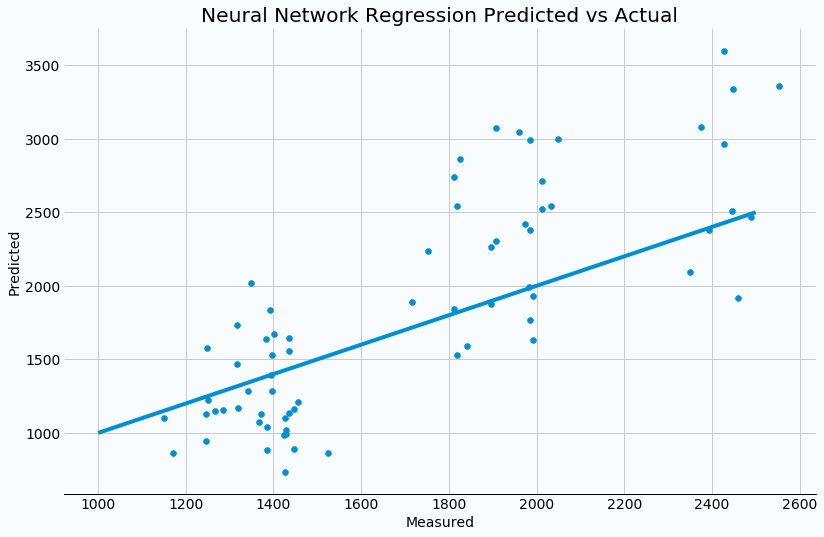

In [212]:
plt.plot( [1000,2500],[1000,2500] )
plt.scatter(y_test, nnr_pred)
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('Neural Network Regression Predicted vs Actual')
plt.show()

### Lasso

In [213]:
from sklearn.linear_model import Lasso

lasso = Lasso()

In [214]:
lasso.fit(X_train, y_train)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [215]:
# Score the model
lasso_score = lasso.score(X_test, y_test)
lasso_score

0.89312602339384795

In [216]:
# Make predictions using the testing set
lasso_pred = lasso.predict(X_test)

In [217]:
print("Root mean squared error: %.2f"
      % sqrt(mean_squared_error(y_test, lasso_pred)))

Root mean squared error: 129.96


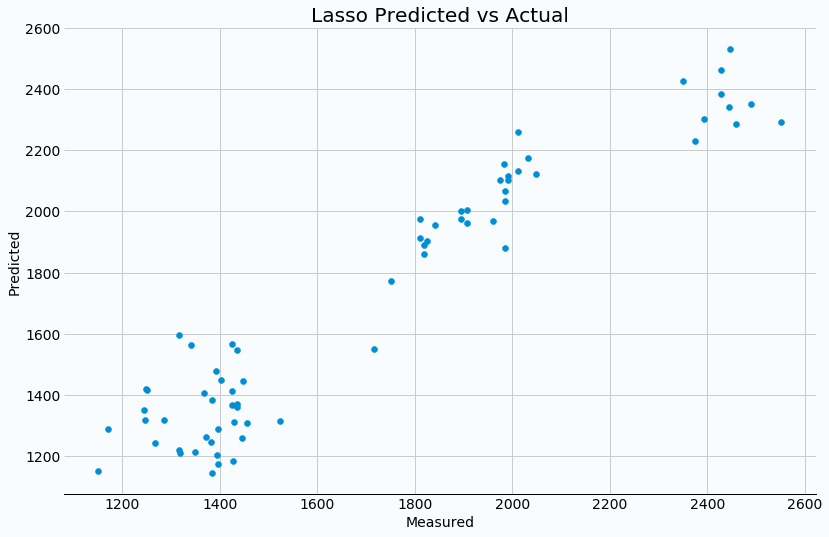

In [218]:
plt.scatter(y_test, lasso_pred)
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('Lasso Predicted vs Actual')
plt.show()

### ElasticNet

In [219]:
from sklearn.linear_model import ElasticNet

elasticnet = ElasticNet()

In [220]:
elasticnet.fit(X_train, y_train)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [221]:
elasticnet_score = elasticnet.score(X_test, y_test)
elasticnet_score

0.89051356926228087

In [222]:
elasticnet_pred = elasticnet.predict(X_test)

In [223]:
# The mean squared error
print("Root mean squared error: %.2f"
      % sqrt(mean_squared_error(y_test, elasticnet_pred)))

Root mean squared error: 131.54


### Rnadom Forest Regression

In [224]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# Create Random Forrest Regressor object
regr_rf = RandomForestRegressor(n_estimators=200, random_state=1234)

In [225]:
# Train the model using the training sets
regr_rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
           oob_score=False, random_state=1234, verbose=0, warm_start=False)

In [226]:
# Score the model
decision_forest_score = regr_rf.score(X_test, y_test)
decision_forest_score

0.98186171767143349

In [227]:
# Make predictions using the testing set
regr_rf_pred = regr_rf.predict(X_test)

In [228]:
# The mean squared error
print("Root mean squared error: %.2f"
      % sqrt(mean_squared_error(y_test, regr_rf_pred)))
# The absolute squared error
print("Mean absolute error: %.2f"
      % mean_absolute_error(y_test, regr_rf_pred))
# Explained variance score: 1 is perfect prediction
print('R-squared: %.2f' % r2_score(y_test, regr_rf_pred))

Root mean squared error: 53.54
Mean absolute error: 40.55
R-squared: 0.98


In [229]:
X.columns

Index(['USD', 'cpi', 'm2', 'm1', 'current', 'capital', 'financial', 'errors',
       'balance', 'USD-lag1', 'USD-lag2', 'USD-lag3', 'USD-lag4', 'm2-lag1',
       'm2-lag2', 'm2-lag3', 'm2-lag4', 'm1-lag1', 'm1-lag2', 'm1-lag3',
       'm1-lag4', 'current-lag1', 'current-lag2', 'current-lag3',
       'current-lag4', 'capital-lag1', 'capital-lag2', 'capital-lag3',
       'capital-lag4', 'financial-lag1', 'financial-lag2', 'financial-lag3',
       'financial-lag4', 'errors-lag1', 'errors-lag2', 'errors-lag3',
       'errors-lag4', 'balance-lag1', 'balance-lag2', 'balance-lag3',
       'balance-lag4', 'month', 'year', 'USD-lag1-diff', 'USD-lag2-diff',
       'USD-lag3-diff'],
      dtype='object')

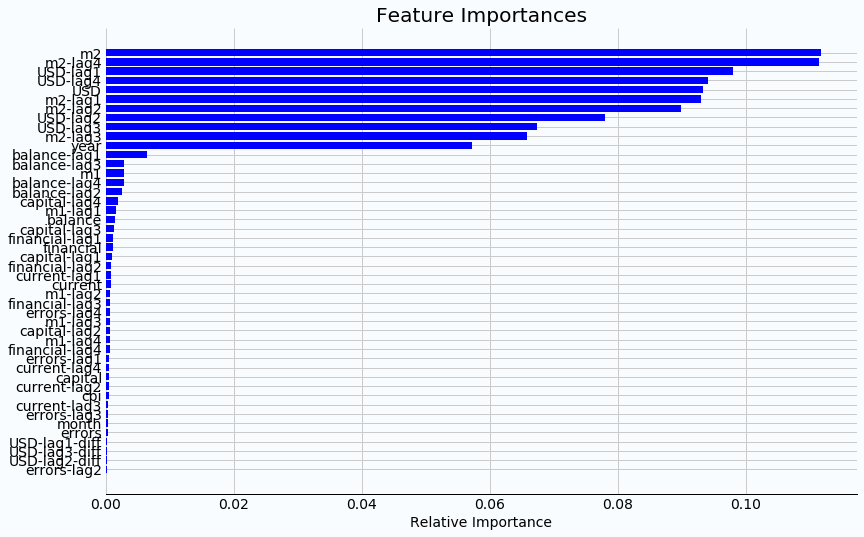

In [230]:
features = X.columns
importances = regr_rf.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()

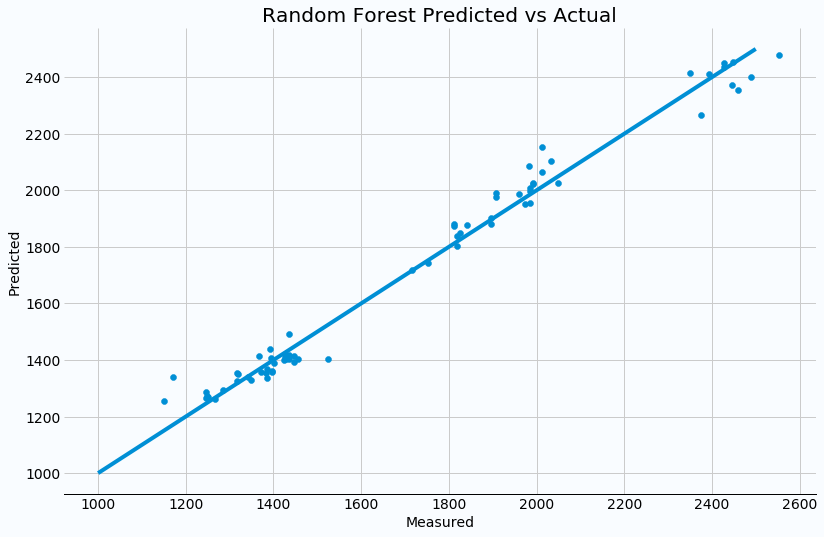

In [231]:
plt.plot( [1000,2500],[1000,2500] )
plt.scatter(y_test, regr_rf_pred)
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('Random Forest Predicted vs Actual')
plt.show()

### Extra Trees Regression

In [232]:
from sklearn.ensemble import ExtraTreesRegressor

extra_tree = ExtraTreesRegressor(n_estimators=200, random_state=1234)

In [233]:
extra_tree.fit(X_train, y_train)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
          oob_score=False, random_state=1234, verbose=0, warm_start=False)

In [234]:
extratree_score = extra_tree.score(X_test, y_test)
extratree_score

0.9910787069468745

In [235]:
extratree_pred = extra_tree.predict(X_test)

In [236]:
print("Root mean squared error: %.2f"
      % sqrt(mean_squared_error(y_test, extratree_pred)))

# The absolute squared error
print("Mean absolute error: %.2f"
      % mean_absolute_error(y_test, extratree_pred))
# Explained variance score: 1 is perfect prediction
print('R-squared: %.2f' % r2_score(y_test, extratree_pred))

Root mean squared error: 37.55
Mean absolute error: 28.12
R-squared: 0.99


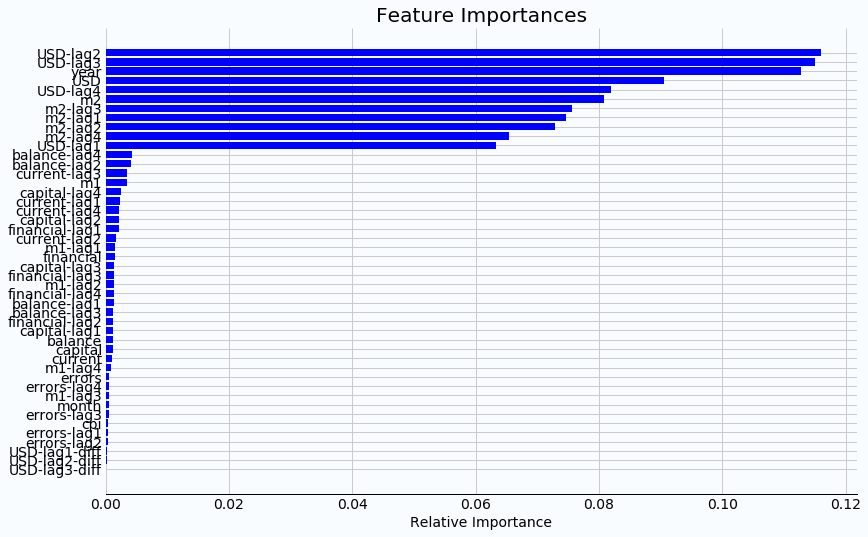

In [237]:
features = X.columns
importances = extra_tree.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()

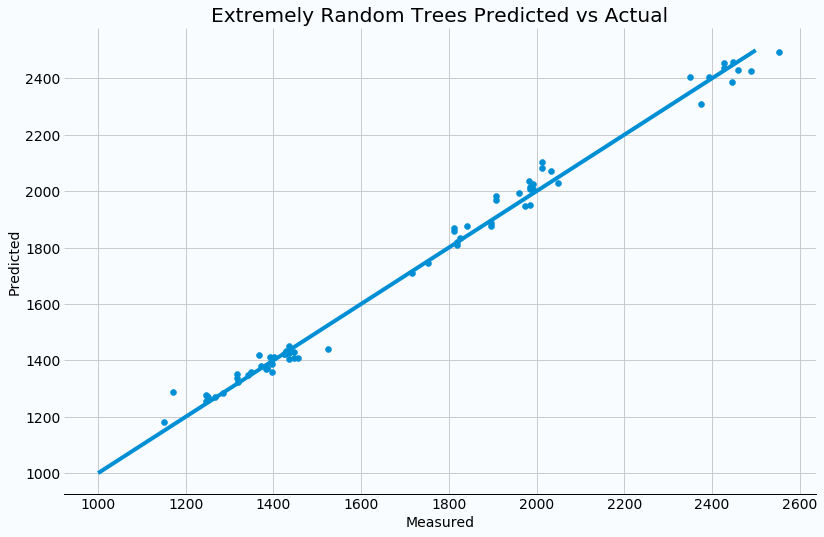

In [238]:
plt.plot( [1000,2500],[1000,2500] )
plt.scatter(y_test, extratree_pred)
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('Extremely Random Trees Predicted vs Actual')
plt.show()

In [239]:
X.tail()

,USD,cpi,m2,m1,current,capital,financial,errors,balance,USD-lag1,...,errors-lag4,balance-lag1,balance-lag2,balance-lag3,balance-lag4,month,year,USD-lag1-diff,USD-lag2-diff,USD-lag3-diff
Date,,,,,,,,,,,,,,,,,,,,,
2017-06-30,2349.87,-0.5,13483.2,2719.7,-122.2,14.0,-247.4,-49.6,1175.2,2397.97,...,-122.7,1010.5,781.9,523.7,334.2,6,2017,-48.10,-21.45,-28.03
2017-07-31,2444.95,0.0,13999.6,2584.2,-226.8,26.8,-486.9,-11.0,1183.6,2349.87,...,-122.7,1175.2,1010.5,781.9,523.7,7,2017,95.08,-48.10,-21.45
2017-08-31,2430.05,0.8,14526.3,2759.0,-226.8,26.8,-486.9,-11.0,1348.1,2444.95,...,-49.6,1183.6,1175.2,1010.5,781.9,8,2017,-14.90,95.08,-48.10
2017-09-30,2464.43,0.2,14749.7,2800.4,-226.8,26.8,-486.9,-11.0,1452.1,2430.05,...,-49.6,1348.1,1183.6,1175.2,1010.5,9,2017,34.38,-14.90,95.08
2017-10-31,2456.17,0.4,14520.7,2626.5,-617.4,21.3,-1789.0,65.1,1658.6,2464.43,...,-49.6,1452.1,1348.1,1183.6,1175.2,10,2017,-8.26,34.38,-14.90


# Evaluate Models

In [240]:
print("Model MMAE:")
print("Linear regression MAE: %.2f"
      % mean_absolute_error(y_test, lin_pred))
print("Neural network MAE: %.2f"
      % mean_absolute_error(y_test, nnr_pred))
print("Lasso MAE: %.2f"
      % mean_absolute_error(y_test, lasso_pred))
print("ElasticNet MAE: %2f"
      % mean_absolute_error(y_test, elasticnet_pred))
print("Random forest MAE: %.2f"
      % mean_absolute_error(y_test, regr_rf_pred))
print("Extra Trees MAE: %.2f"
      % mean_absolute_error(y_test, extratree_pred))

Model MMAE:
Linear regression MAE: 111.53
Neural network MAE: 394.42
Lasso MAE: 111.70
ElasticNet MAE: 111.569868
Random forest MAE: 40.55
Extra Trees MAE: 28.12


## Measuring Test Set Accuracy

In [241]:
df.head()

,USD,cpi,m2,m1,current,capital,financial,errors,balance,y3,...,errors-lag4,balance-lag1,balance-lag2,balance-lag3,balance-lag4,month,year,USD-lag1-diff,USD-lag2-diff,USD-lag3-diff
Date,,,,,,,,,,,,,,,,,,,,,
2008-05-31,1161.37,4.3,2516.2,620.6,-130.6,20.1,282.8,-161.4,-153.4,1150.91,...,-147.4,-93.5,-19.5,57.3,17.6,5,2008,-3.57,-3.23,-3.65
2008-06-30,1158.12,0.2,2564.3,624.9,-130.6,20.1,282.8,-161.4,-201.0,1146.09,...,-147.4,-153.4,-93.5,-19.5,57.3,6,2008,-3.25,-3.57,-3.23
2008-07-31,1155.35,0.0,2595.2,624.0,-220.3,22.6,337.7,-241.3,-360.1,1144.37,...,-147.4,-201.0,-153.4,-93.5,-19.5,7,2008,-2.77,-3.25,-3.57
2008-08-31,1150.91,3.7,2576.4,642.2,-220.3,22.6,337.7,-241.3,-435.2,1170.64,...,-161.4,-360.1,-201.0,-153.4,-93.5,8,2008,-4.44,-2.77,-3.25
2008-09-30,1146.09,0.5,2522.3,603.5,-220.3,22.6,337.7,-241.3,-466.4,1267.51,...,-161.4,-435.2,-360.1,-201.0,-153.4,9,2008,-4.82,-4.44,-2.77


In [242]:
usd = pd.DataFrame(df.index)
usd['Date'] = pd.to_datetime(usd.Date)
usd = usd.set_index('Date', drop=False)

In [243]:
usd['USD'] = df['USD']

In [244]:
test = pd.DataFrame(X_test.index)
test['Date'] = pd.to_datetime(test.Date)

In [245]:
test['y3'] = extratree_pred[:,0]
test['y6'] = extratree_pred[:,1]
test['y12'] = extratree_pred[:,2]

In [246]:
usd = usd.merge(test, how='left', on='Date')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 'Date' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  """Entry point for launching an IPython kernel.


In [247]:
usd.head(10)

,Date,USD,y3,y6,y12
0,2008-05-31,1161.37,1180.15720,1289.05325,1431.8273
1,2008-06-30,1158.12,NaN,NaN,NaN
2,2008-07-31,1155.35,NaN,NaN,NaN
3,2008-08-31,1150.91,NaN,NaN,NaN
4,2008-09-30,1146.09,1269.87885,1438.92745,1426.7369
5,2008-10-31,1144.37,NaN,NaN,NaN
6,2008-11-30,1170.64,NaN,NaN,NaN
7,2008-12-31,1267.51,NaN,NaN,NaN
8,2009-01-31,1381.66,NaN,NaN,NaN
9,2009-02-28,1470.17,NaN,NaN,NaN


In [248]:
usd['y3'] = usd['y3'].shift(3)
usd['y6'] = usd['y6'].shift(6)
usd['y12'] = usd['y12'].shift(12)

In [249]:
usd.head(10)

,Date,USD,y3,y6,y12
0,2008-05-31,1161.37,NaN,NaN,NaN
1,2008-06-30,1158.12,NaN,NaN,NaN
2,2008-07-31,1155.35,NaN,NaN,NaN
3,2008-08-31,1150.91,1180.15720,NaN,NaN
4,2008-09-30,1146.09,NaN,NaN,NaN
5,2008-10-31,1144.37,NaN,NaN,NaN
6,2008-11-30,1170.64,NaN,1289.05325,NaN
7,2008-12-31,1267.51,1269.87885,NaN,NaN
8,2009-01-31,1381.66,NaN,NaN,NaN
9,2009-02-28,1470.17,NaN,NaN,NaN


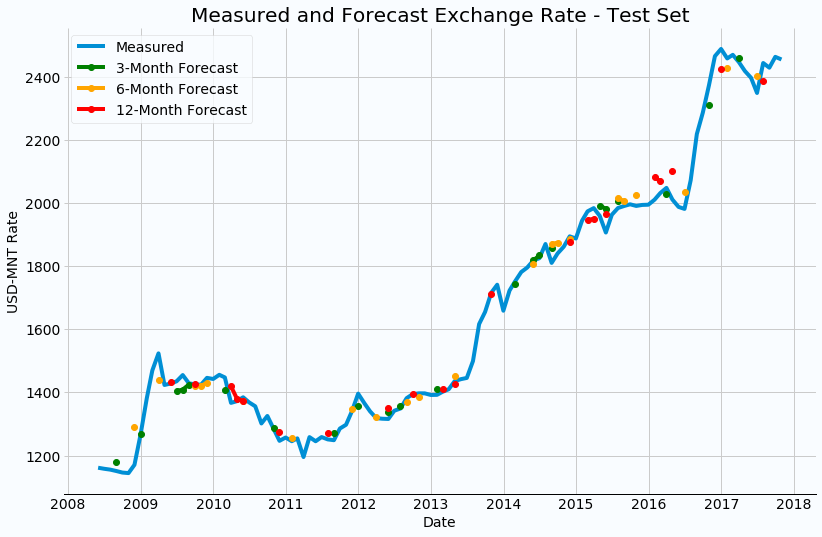

In [250]:
fig, ax = plt.subplots()
ax.plot(usd['Date'], usd['USD'])
ax.plot(usd['Date'], usd['y3'], color='green',marker='o')
ax.plot(usd['Date'], usd['y6'], color='orange',marker='o')
ax.plot(usd['Date'], usd['y12'], color='red',marker='o')
ax.set_xlabel('Date')
ax.set_ylabel('USD-MNT Rate')
ax.set_title("Measured and Forecast Exchange Rate - Test Set")
ax.legend(labels=['Measured', '3-Month Forecast', '6-Month Forecast', '12-Month Forecast'])
plt.savefig('Output/Measured-Forecast.png', dpi=300)

## Make Forecast

In [251]:
forecast.head()

,USD,cpi,m2,m1,current,capital,financial,errors,balance,USD-lag1,...,errors-lag4,balance-lag1,balance-lag2,balance-lag3,balance-lag4,month,year,USD-lag1-diff,USD-lag2-diff,USD-lag3-diff
Date,,,,,,,,,,,,,,,,,,,,,
2018-06-30,2462.82,0.5,17342.9,3352.9,-319.4,26.5,-376.6,-176.7,822.2,2409.8,...,66.9,706.4,543.4,351.94,112.4,6,2018,53.02,6.94,10.09


In [252]:
forecast1 = extra_tree.predict(forecast)

In [253]:
forecast1

array([[ 2409.3596 ,  2421.31845,  2454.89615]])

In [254]:
forecast1 = pd.DataFrame(forecast1)

In [255]:
forecast1 = forecast1.melt()

In [256]:
forecast1

,variable,value
0,0,2409.35960
1,1,2421.31845
2,2,2454.89615


In [257]:
forecast1 = forecast1.replace({'variable': {0: '2018-09-30', 1: '2018-12-31', 2: '2019-06-30'}})

In [258]:
forecast1

,variable,value
0,2018-09-30,2409.35960
1,2018-12-31,2421.31845
2,2019-06-30,2454.89615


In [259]:
forecast1['variable'] = pd.to_datetime(forecast1['variable'])

In [260]:
forecast2.head(5)

,USD,cpi,m2,m1,current,capital,financial,errors,balance
Date,,,,,,,,,
2014-11-30,1895.17,0.7,9927.0,1689.7,-81.3,20.9,325.0,7.4,358.2
2014-12-31,1888.44,0.8,10634.3,1816.4,-81.3,20.9,325.0,7.4,537.9
2015-01-31,1944.78,0.7,10313.1,1578.7,-60.2,21.7,-29.0,-203.6,225.4
2015-02-28,1974.52,0.4,10229.0,1586.5,-60.2,21.7,-29.0,-203.6,290.8
2015-03-31,1984.69,0.8,9902.3,1445.9,-60.2,21.7,-29.0,-203.6,375.9


In [261]:
forecast2['Date'] = pd.to_datetime(forecast2.index)

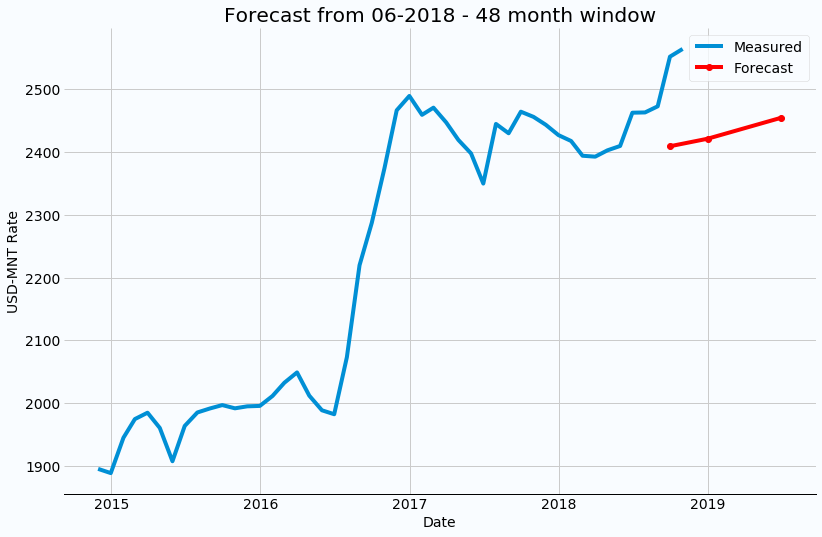

In [263]:
fig, ax = plt.subplots()
ax.plot(forecast2['Date'], forecast2['USD'])
ax.plot(forecast1['variable'], forecast1['value'], color='red',marker='o')
ax.set_xlabel('Date')
ax.set_ylabel('USD-MNT Rate')
ax.set_title("Forecast from 06-2018 - 48 month window")
ax.legend(labels=['Measured', 'Forecast'])